In [1]:
from hlm_basic.ssn import GenerateNetwork, UpstreamArea
from hlm_basic.watershed import Watershed
from hlm_basic.tools import GetForcing, Set_InitialConditions, plot_sim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
l_id, connectivity, h_order, nextlink = GenerateNetwork(5)
n_hills = len(connectivity)
a_hill = 0.5 * 0.5 #km2
A_h = np.array([a_hill*10**6 for i in range(n_hills)]) #m2
L_i = np.array([0.5*10**3 for i in range(n_hills)])  #m
A_i = UpstreamArea(a_hill, connectivity, h_order) #km2

In [3]:
forcing, raw_data = GetForcing("../data/rainfall/2010_timeseries.csv", '2010-06-01','2010-08-01')
te = len(forcing)-1 # -1 is used to prevent IndexError

In [4]:
dams = [9,27,36,45,63,90,108,117,126,135,144,153,171,189,198,207,216,225,234] 
order_3 = [9,36,45,63,90,117,126,144,153,171,198,207,225,234] 
order_4 = [27, 189, 216, 135, 108]
n_dams = len(dams)
# Parameters of each dam (For Model 256)
_alpha = [0.5 for _ in range(n_dams)]
c1 = [0.6 for _ in range(n_dams)]
c2 = [3.0 for _ in range(n_dams)]

H_spill = []
H_max = []
diam = []
S_max = []
L_spill = []
L_crest = []
for dam in dams:
    if dam in order_3:
        H_spill.append(4.5)
        H_max.append(5)
        diam.append(1.0)
        S_max.append(200000)
        L_spill.append(2.0)
        L_crest.append(5.0)
    elif dam in order_4:
        H_spill.append(4.5)
        H_max.append(5.0)
        diam.append(1.0)
        S_max.append(300000)
        L_spill.append(4.0)
        L_crest.append(10.0)

In [6]:
SSN1 = Watershed(Model=254)
SSN1.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
SSN1.initialize(q=q, s_p=s_p, s_t=s_t, s_s=s_s)
dc_nodam = SSN1.Run_254( [0, te],forcing, rtol=1e-4, t_eval=np.arange(0,te,5))

Model 254 is being used!
87839

In [7]:
SSN2 = Watershed(Model=255)
SSN2.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN2.dam_ids = dams
SSN2.set_dam_state(states=[1 for _ in range(n_dams)])
dam_params256 = SSN2.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]
SSN2.initialize(q=q, S = S, s_t =s_t, s_p =s_p, s_s=s_s)

dc_passiveRK45, st_passiveRK45 = SSN2.Run_256( [0, te], forcing, dam_params256, method='RK45')

Model 255 (254 with_dams) is being used!
87839

In [8]:
SSN3 = Watershed(Model=255)
SSN3.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN3.dam_ids = dams
dam_params256 = SSN3.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]
update = 15 #mins
t0 = 0
columns = SSN3.__columns__()
dc_bug15 = pd.DataFrame(columns =columns[0])
st_bug15  = pd.DataFrame(columns =columns[1])
while t0 < te:
    if t0 !=0:
        q, S, s_p, s_t, s_s = SSN3.Get_Snapshot()
    states = [1 for _ in range(n_dams)]
    SSN3.set_dam_state(states=states)
    SSN3.initialize(q=q, S=S, s_p=s_p,s_t =s_t, s_s=s_s)
    try:
        dc, st = SSN3.Run_256([t0, t0+update], forcing, dam_params256, method='RK45', t_eval = np.arange(t0, t0+update, 5))
    except IndexError:
        break    
    
    t0 += update
    dc_bug15 = dc_bug15.append(dc)
    st_bug15 = st_bug15.append(st)

Model 255 (254 with_dams) is being used!
87840

In [9]:
SSN4 = Watershed(Model=255)
SSN4.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN4.dam_ids = dams
dam_params256 = SSN4.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]

update = 15 #mins
t0 = 0
columns = SSN4.__columns__()
dc_NObugRK45_15 = pd.DataFrame(columns =columns[0])
st_NObugRK45_15  = pd.DataFrame(columns =columns[1])
while t0 < te:
    if t0 !=0:
        q, S, s_p, s_t, s_s = SSN4.Get_Snapshot()
    states = [1 for _ in range(n_dams)]
    SSN4.set_dam_state(states=states)
    SSN4.initialize(q=q, S=S, s_p=s_p,s_t =s_t, s_s=s_s)
    try:
        dc, st = SSN4.Run_256([t0, t0+update], forcing, dam_params256, rtol=1e-7,method='RK45')
    except IndexError:
        break
    t0 += update
    dc_NObugRK45_15 = dc_NObugRK45_15.append(dc)
    st_NObugRK45_15 = st_NObugRK45_15.append(st)

Model 255 (254 with_dams) is being used!
87845

In [10]:
SSN5 = Watershed(Model=255)
SSN5.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN5.dam_ids = dams
dam_params256 = SSN5.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]

update = 15 #mins
t0 = 0
columns = SSN5.__columns__()
dc_NObugDOP853_15 = pd.DataFrame(columns =columns[0])
st_NObugDOP853_15  = pd.DataFrame(columns =columns[1])
while t0 < te:
    if t0 !=0:
        q, S, s_p, s_t, s_s = SSN5.Get_Snapshot()
    states = [1 for _ in range(n_dams)]
    SSN5.set_dam_state(states=states)
    SSN5.initialize(q=q, S=S, s_p=s_p,s_t =s_t, s_s=s_s)
    try:
        dc, st = SSN5.Run_256([t0, t0+update], forcing, dam_params256, rtol=1e-7,method='DOP853')
    except IndexError:
        break
    t0 += update
    dc_NObugDOP853_15 = dc_NObugDOP853_15.append(dc)
    st_NObugDOP853_15 = st_NObugDOP853_15.append(st)

Model 255 (254 with_dams) is being used!
87845

In [11]:
SSN6 = Watershed(Model=255)
SSN6.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN6.dam_ids = dams
dam_params256 = SSN6.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]

update = 60 #mins
t0 = 0
columns = SSN6.__columns__()
dc_NObugRK45_1h = pd.DataFrame(columns =columns[0])
st_NObugRK45_1h  = pd.DataFrame(columns =columns[1])
while t0 < te:
    if t0 !=0:
        q, S, s_p, s_t, s_s = SSN6.Get_Snapshot()
    states = [1 for _ in range(n_dams)]
    SSN6.set_dam_state(states=states)
    SSN6.initialize(q=q, S=S, s_p=s_p,s_t =s_t, s_s=s_s)
    try:
        dc, st = SSN6.Run_256([t0, t0+update], forcing, dam_params256,method='RK45')
    except IndexError:
        break
    t0 += update
    dc_NObugRK45_1h = dc_NObugRK45_1h.append(dc)
    st_NObugRK45_1h = st_NObugRK45_1h.append(st)

Model 255 (254 with_dams) is being used!
87846

In [12]:
SSN7 = Watershed(Model=255)
SSN7.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN7.dam_ids = dams
dam_params256 = SSN7.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]

update = 5 #mins
t0 = 0
columns = SSN7.__columns__()
dc_NObugRK45_5min = pd.DataFrame(columns =columns[0])
st_NObugRK45_5min  = pd.DataFrame(columns =columns[1])
while t0 < te:
    if t0 !=0:
        q, S, s_p, s_t, s_s = SSN7.Get_Snapshot()
    states = [1 for _ in range(n_dams)]
    SSN7.set_dam_state(states=states)
    SSN7.initialize(q=q, S=S, s_p=s_p,s_t =s_t, s_s=s_s)
    try:
        dc, st = SSN7.Run_256([t0, t0+update], forcing, dam_params256,method='RK45')
    except IndexError:
        break
    t0 += update
    dc_NObugRK45_5min = dc_NObugRK45_5min.append(dc)
    st_NObugRK45_5min = st_NObugRK45_5min.append(st)

Model 255 (254 with_dams) is being used!
87840

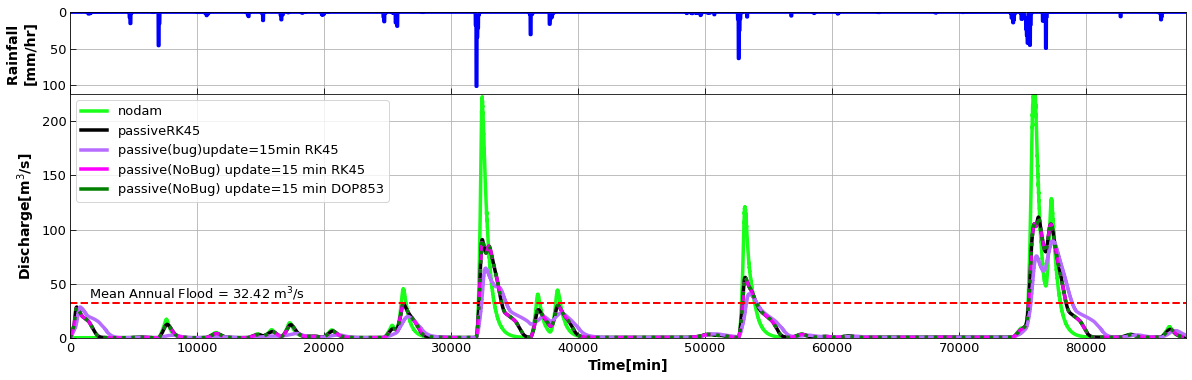

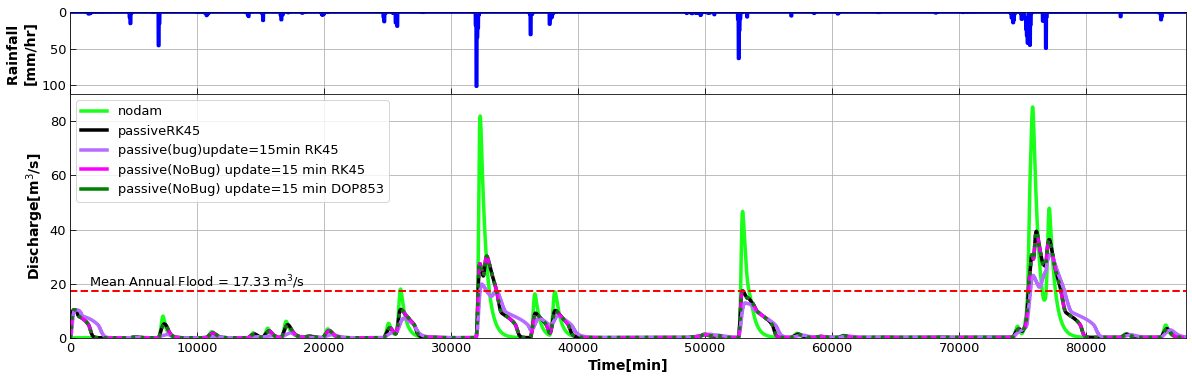

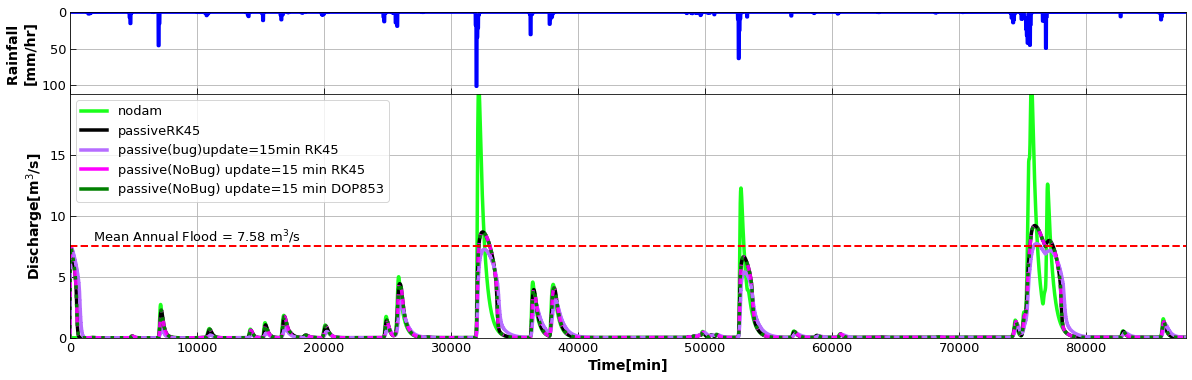

In [13]:
s_name = '_Bug_solver_Tests_1' 
pltkwargs = np.array([{'label':'nodam', 'color':'#1AFF1A'}, {'label':'passiveRK45', 'color':'#000000','alpha':1.0}, {'label':'passive(bug)update=15min RK45', 'color':'#b66dff','alpha':1, 'linestyle':'solid'},{'label':'passive(NoBug) update=15 min RK45', 'color':'magenta', 'alpha':0.9,'linestyle':'dashdot'},  {'label':'passive(NoBug) update=15 min DOP853', 'color':'green','alpha':1.0, 'linestyle':'dotted'}])
pltKwargs = pltkwargs[[0,1,2,3,4]]
dataset = [dc_nodam,dc_passiveRK45, dc_bug15, dc_NObugRK45_15, dc_NObugDOP853_15]

plot_sim(0, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,225,50], area=60.75, save='../../Supp_DamStudy/solve_ivp/Hydro0'+s_name)
plot_sim(81, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,90,20], area=20.25, save='../../Supp_DamStudy/solve_ivp/Hydro81'+s_name)
plot_sim(35, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,20,5], area=4.75,save='../../Supp_DamStudy/solve_ivp/Hydro35'+s_name)

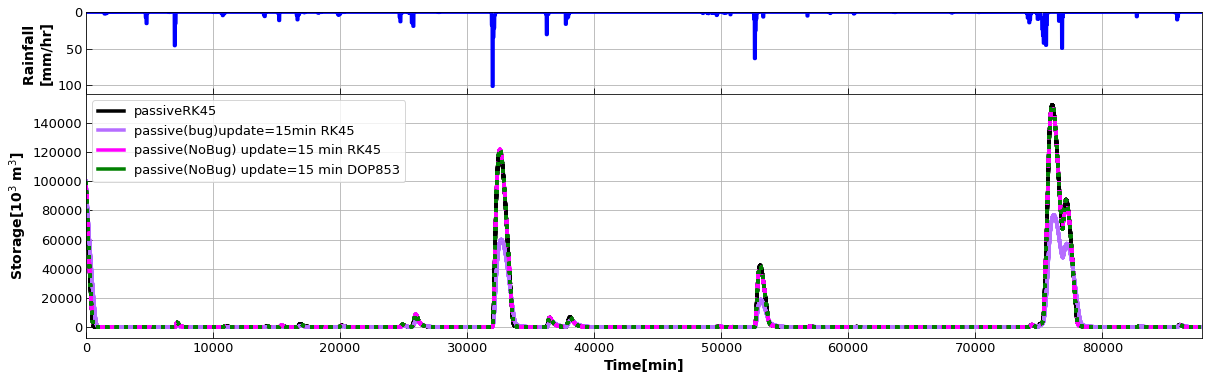

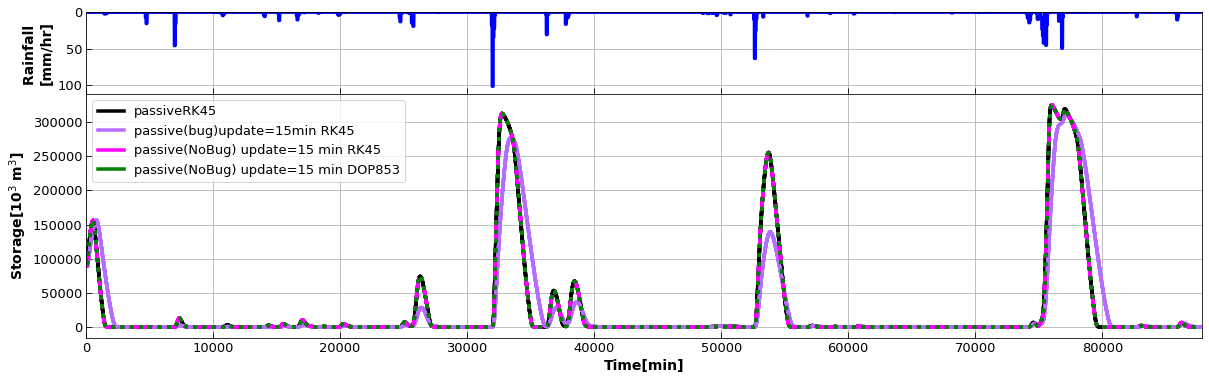

In [14]:
order_3 = [9,36,45,63,90,117,126,144,153,171,198,207,225,234] 
order_4 = [27, 189, 216, 135, 108]
pltKwargs = pltkwargs[[1,2,3,4]]
dataset = [st_passiveRK45, st_bug15, st_NObugRK45_15, st_NObugDOP853_15]
plot_sim(order_3, forcing, dataset, pltKwargs, d_type='storage', save='../../Supp_DamStudy/solve_ivp/Order3_'+s_name)
plot_sim(order_4, forcing, dataset, pltKwargs, d_type='storage',save='../../Supp_DamStudy/solve_ivp/Order4_'+s_name)

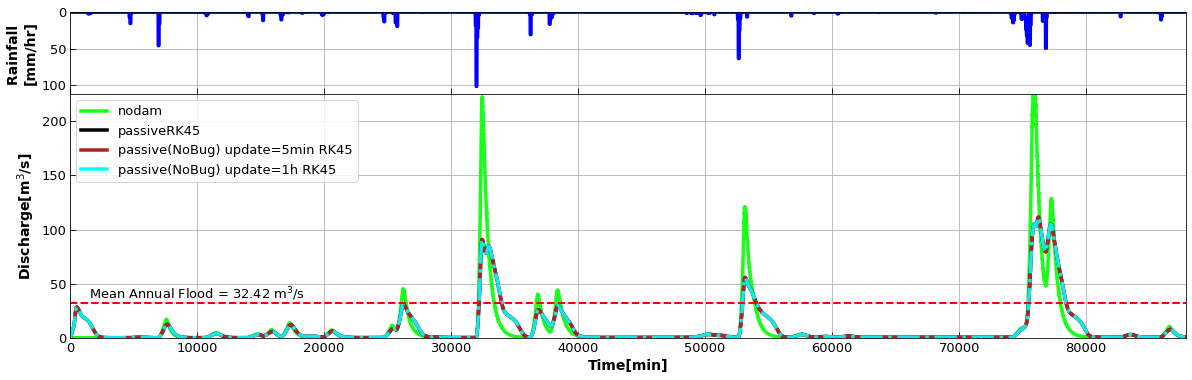

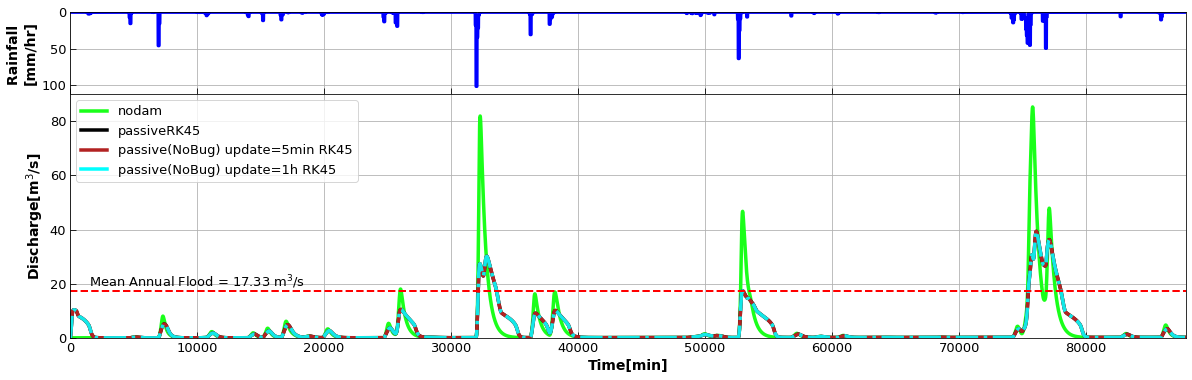

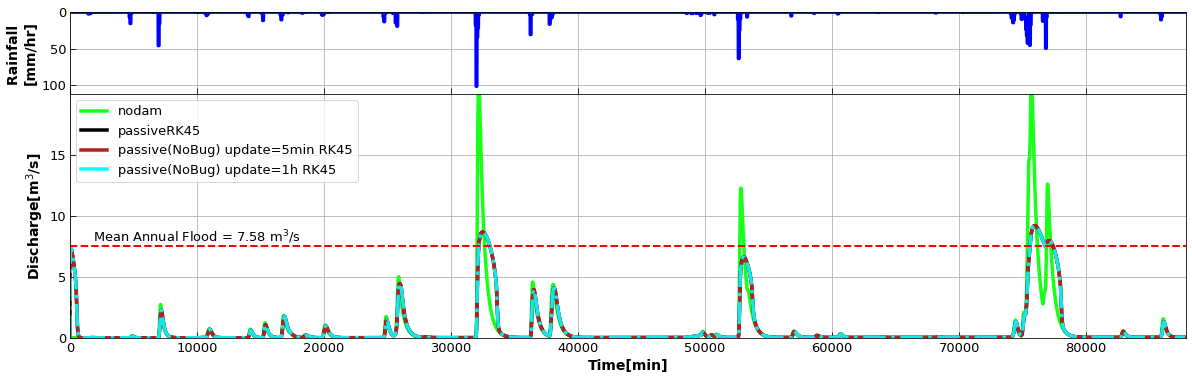

In [15]:
s_name = '_Bug_solver_Tests_2' 
pltkwargs = np.array([{'label':'nodam', 'color':'#1AFF1A'}, {'label':'passiveRK45', 'color':'#000000','alpha':1.0}, {'label':'passive(NoBug) update=5min RK45', 'color':'firebrick','alpha':1, 'linestyle':'solid'},{'label':'passive(NoBug) update=1h RK45', 'color':'cyan', 'alpha':0.9,'linestyle':'dashdot'}])
pltKwargs = pltkwargs[[0,1,2,3]]
dataset = [dc_nodam,dc_passiveRK45, dc_NObugRK45_5min,dc_NObugRK45_1h]

plot_sim(0, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,225,50], area=60.75, save='../../Supp_DamStudy/solve_ivp/Hydro0'+s_name)
plot_sim(81, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,90,20], area=20.25, save='../../Supp_DamStudy/solve_ivp/Hydro81'+s_name)
plot_sim(35, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,20,5], area=4.75,save='../../Supp_DamStudy/solve_ivp/Hydro35'+s_name)

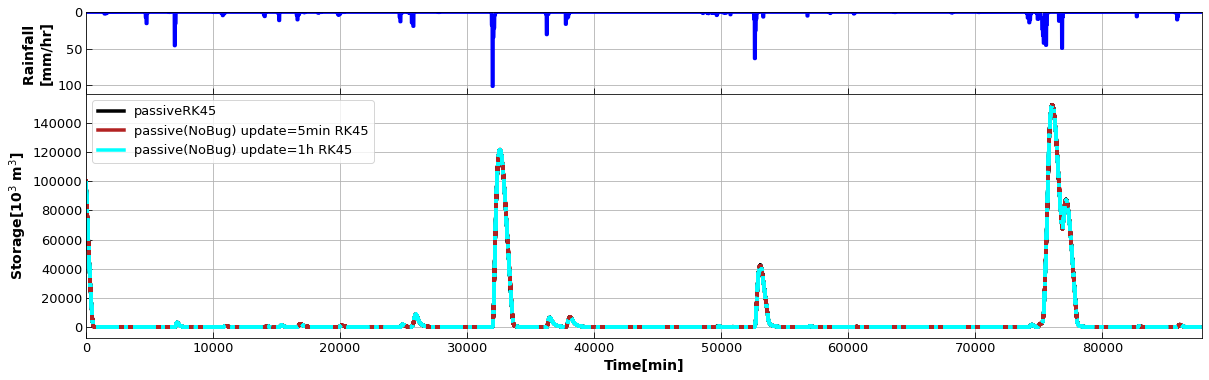

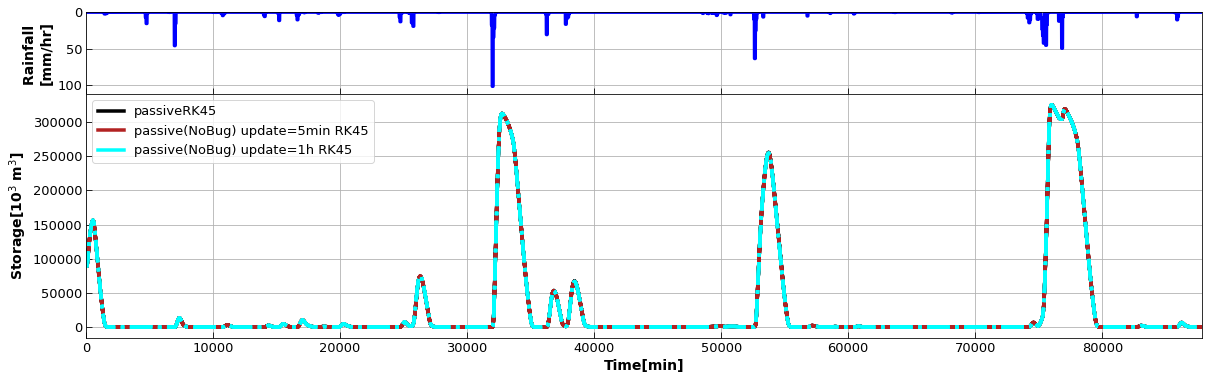

In [16]:
order_3 = [9,36,45,63,90,117,126,144,153,171,198,207,225,234] 
order_4 = [27, 189, 216, 135, 108]
pltKwargs = pltkwargs[[1,2,3]]
dataset = [st_passiveRK45, st_NObugRK45_5min,st_NObugRK45_1h]
plot_sim(order_3, forcing, dataset, pltKwargs, d_type='storage', save='../../Supp_DamStudy/solve_ivp/Order3_'+s_name)
plot_sim(order_4, forcing, dataset, pltKwargs, d_type='storage',save='../../Supp_DamStudy/solve_ivp/Order4_'+s_name)